In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    init_channel = 32
    
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=init_channel, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=int(init_channel*(2**int((i+1)/3))), 
                          strides=1, padding='same', activation='relu'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
flatten (Flatten)            (None, 512000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 512000)            0         
_________________________________________________________________
dense (Dense)                (None, 16)                8192016   
Total params: 8,192,208
Trainable params: 8,192,208
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 32)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          10304     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.2855 - acc: 0.2659
Epoch 00001: val_loss improved from inf to 1.81828, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_4_conv_checkpoint/001-1.8183.hdf5
36805/36805 [==============================] - 27s 740us/sample - loss: 2.2843 - acc: 0.2665 - val_loss: 1.8183 - val_acc: 0.4442
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6729 - acc: 0.4720
Epoch 00002: val_loss improved from 1.81828 to 1.51419, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_4_conv_checkpoint/002-1.5142.hdf5
36805/36805 [==============================] - 25s 680us/sample - loss: 1.6724 - acc: 0.4722 - val_loss: 1.5142 - val_acc: 0.5167
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4608 - acc: 0.5468
Epoch 00003: val_loss improved from 1.51419 to 1.37636, saving 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3507 - acc: 0.8891
Epoch 00026: val_loss did not improve from 1.10260
36805/36805 [==============================] - 24s 662us/sample - loss: 0.3507 - acc: 0.8891 - val_loss: 1.2128 - val_acc: 0.6827
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3331 - acc: 0.8932
Epoch 00027: val_loss did not improve from 1.10260
36805/36805 [==============================] - 24s 663us/sample - loss: 0.3331 - acc: 0.8931 - val_loss: 1.2901 - val_acc: 0.6660
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3156 - acc: 0.9007
Epoch 00028: val_loss did not improve from 1.10260
36805/36805 [==============================] - 24s 661us/sample - loss: 0.3156 - acc: 0.9007 - val_loss: 1.2076 - val_acc: 0.6937
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2992 - acc: 0.9067
Epoch 00029: val_loss did not improve from 1.10260
36805/36805 [=====

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1283 - acc: 0.9598
Epoch 00056: val_loss did not improve from 1.10260
36805/36805 [==============================] - 24s 664us/sample - loss: 0.1283 - acc: 0.9598 - val_loss: 1.4131 - val_acc: 0.7179
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1355 - acc: 0.9578
Epoch 00057: val_loss did not improve from 1.10260
36805/36805 [==============================] - 24s 663us/sample - loss: 0.1355 - acc: 0.9578 - val_loss: 1.4038 - val_acc: 0.7088
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1271 - acc: 0.9601
Epoch 00058: val_loss did not improve from 1.10260
36805/36805 [==============================] - 25s 668us/sample - loss: 0.1271 - acc: 0.9600 - val_loss: 1.4253 - val_acc: 0.7130
Epoch 59/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1239 - acc: 0.9618
Epoch 00059: val_loss did not improve from 1.10260
36805/36805 [=====

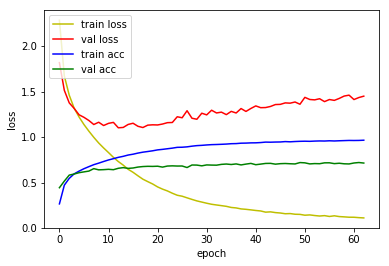

4815/4815 [==============================] - 2s 360us/sample - loss: 1.1983 - acc: 0.6339
Loss: 1.1983275781168001 Accuracy: 0.63385254

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3008 - acc: 0.2468
Epoch 00001: val_loss improved from inf to 1.72951, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_5_conv_checkpoint/001-1.7295.hdf5
36805/36805 [==============================] - 27s 723us/sample - loss: 2.3007 - acc: 0.2468 - val_loss: 1.7295 - val_acc: 0.4491
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6506 - acc: 0.4657
Epoch 00002: val_loss improved from 1.72951 to 1.47672, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_5_conv_checkpoint/002-1.4767.hdf5
36805/36805 [==============================] - 26s 697us/sample - loss: 1.6506 - acc: 0.4657 - val_loss: 1.4767 - val_acc: 0.5367
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

36736/36805 [============================>.] - ETA: 0s - loss: 0.5711 - acc: 0.8235
Epoch 00023: val_loss improved from 0.74847 to 0.74618, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_5_conv_checkpoint/023-0.7462.hdf5
36805/36805 [==============================] - 26s 699us/sample - loss: 0.5708 - acc: 0.8236 - val_loss: 0.7462 - val_acc: 0.7792
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5482 - acc: 0.8333
Epoch 00024: val_loss improved from 0.74618 to 0.73775, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_5_conv_checkpoint/024-0.7378.hdf5
36805/36805 [==============================] - 26s 695us/sample - loss: 0.5484 - acc: 0.8333 - val_loss: 0.7378 - val_acc: 0.7841
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5371 - acc: 0.8333
Epoch 00025: val_loss improved from 0.73775 to 0.72146, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_5_conv_checkpoint/025-0.7215.hdf5
36805/36805 [=====

36800/36805 [============================>.] - ETA: 0s - loss: 0.2766 - acc: 0.9101
Epoch 00050: val_loss did not improve from 0.70595
36805/36805 [==============================] - 26s 697us/sample - loss: 0.2766 - acc: 0.9101 - val_loss: 0.7312 - val_acc: 0.8097
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2699 - acc: 0.9109
Epoch 00051: val_loss did not improve from 0.70595
36805/36805 [==============================] - 25s 693us/sample - loss: 0.2699 - acc: 0.9109 - val_loss: 0.7429 - val_acc: 0.8143
Epoch 52/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2655 - acc: 0.9148
Epoch 00052: val_loss did not improve from 0.70595
36805/36805 [==============================] - 26s 697us/sample - loss: 0.2656 - acc: 0.9147 - val_loss: 0.7435 - val_acc: 0.8120
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2531 - acc: 0.9185
Epoch 00053: val_loss did not improve from 0.70595
36805/36805 [==================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1746 - acc: 0.9432
Epoch 00080: val_loss did not improve from 0.70595
36805/36805 [==============================] - 26s 696us/sample - loss: 0.1746 - acc: 0.9432 - val_loss: 0.7809 - val_acc: 0.8183
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1687 - acc: 0.9448
Epoch 00081: val_loss did not improve from 0.70595
36805/36805 [==============================] - 26s 701us/sample - loss: 0.1687 - acc: 0.9448 - val_loss: 0.8028 - val_acc: 0.8206
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1686 - acc: 0.9447
Epoch 00082: val_loss did not improve from 0.70595
36805/36805 [==============================] - 26s 699us/sample - loss: 0.1686 - acc: 0.9447 - val_loss: 0.8378 - val_acc: 0.8097
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1686 - acc: 0.9446
Epoch 00083: val_loss did not improve from 0.70595
36805/36805 [=====

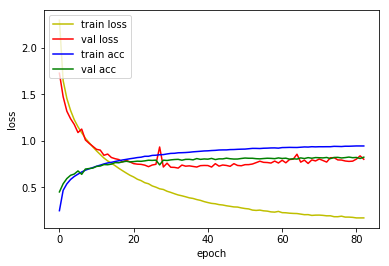

4815/4815 [==============================] - 2s 381us/sample - loss: 0.8117 - acc: 0.7701
Loss: 0.8116677548655097 Accuracy: 0.77009344

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3715 - acc: 0.2211
Epoch 00001: val_loss improved from inf to 1.83005, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_6_conv_checkpoint/001-1.8301.hdf5
36805/36805 [==============================] - 28s 772us/sample - loss: 2.3715 - acc: 0.2212 - val_loss: 1.8301 - val_acc: 0.4156
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7145 - acc: 0.4390
Epoch 00002: val_loss improved from 1.83005 to 1.46157, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_6_conv_checkpoint/002-1.4616.hdf5
36805/36805 [==============================] - 26s 717us/sample - loss: 1.7145 - acc: 0.4390 - val_loss: 1.4616 - val_acc: 0.5418
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - l

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5833 - acc: 0.8221
Epoch 00024: val_loss improved from 0.57179 to 0.54720, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_6_conv_checkpoint/024-0.5472.hdf5
36805/36805 [==============================] - 26s 713us/sample - loss: 0.5834 - acc: 0.8220 - val_loss: 0.5472 - val_acc: 0.8421
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5685 - acc: 0.8281
Epoch 00025: val_loss improved from 0.54720 to 0.54035, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_6_conv_checkpoint/025-0.5403.hdf5
36805/36805 [==============================] - 26s 713us/sample - loss: 0.5684 - acc: 0.8281 - val_loss: 0.5403 - val_acc: 0.8423
Epoch 26/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.5467 - acc: 0.8335
Epoch 00026: val_loss improved from 0.54035 to 0.53102, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_6_conv_checkpoint/026-0.5310.hdf5
36805

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3410 - acc: 0.8950
Epoch 00049: val_loss did not improve from 0.39740
36805/36805 [==============================] - 26s 709us/sample - loss: 0.3409 - acc: 0.8950 - val_loss: 0.3997 - val_acc: 0.8861
Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3326 - acc: 0.8965
Epoch 00050: val_loss did not improve from 0.39740
36805/36805 [==============================] - 26s 714us/sample - loss: 0.3324 - acc: 0.8966 - val_loss: 0.4155 - val_acc: 0.8896
Epoch 51/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3266 - acc: 0.8985
Epoch 00051: val_loss did not improve from 0.39740
36805/36805 [==============================] - 26s 710us/sample - loss: 0.3265 - acc: 0.8985 - val_loss: 0.3998 - val_acc: 0.8924
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3236 - acc: 0.8984
Epoch 00052: val_loss improved from 0.39740 to 0.38407, saving model 

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2353 - acc: 0.9246
Epoch 00077: val_loss did not improve from 0.36610
36805/36805 [==============================] - 26s 710us/sample - loss: 0.2353 - acc: 0.9246 - val_loss: 0.3743 - val_acc: 0.9010
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2311 - acc: 0.9249
Epoch 00078: val_loss did not improve from 0.36610
36805/36805 [==============================] - 26s 712us/sample - loss: 0.2311 - acc: 0.9249 - val_loss: 0.3773 - val_acc: 0.8996
Epoch 79/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2315 - acc: 0.9245
Epoch 00079: val_loss did not improve from 0.36610
36805/36805 [==============================] - 26s 714us/sample - loss: 0.2316 - acc: 0.9245 - val_loss: 0.3743 - val_acc: 0.9052
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2296 - acc: 0.9262
Epoch 00080: val_loss did not improve from 0.36610
36805/36805 [=====

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1779 - acc: 0.9418
Epoch 00106: val_loss did not improve from 0.35274
36805/36805 [==============================] - 26s 710us/sample - loss: 0.1779 - acc: 0.9418 - val_loss: 0.3753 - val_acc: 0.9124
Epoch 107/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1770 - acc: 0.9418
Epoch 00107: val_loss did not improve from 0.35274
36805/36805 [==============================] - 26s 710us/sample - loss: 0.1771 - acc: 0.9417 - val_loss: 0.3992 - val_acc: 0.9085
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1769 - acc: 0.9429
Epoch 00108: val_loss did not improve from 0.35274
36805/36805 [==============================] - 26s 711us/sample - loss: 0.1769 - acc: 0.9429 - val_loss: 0.3733 - val_acc: 0.9108
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1747 - acc: 0.9416
Epoch 00109: val_loss did not improve from 0.35274
36805/36805 [=

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1424 - acc: 0.9523
Epoch 00136: val_loss did not improve from 0.35274
36805/36805 [==============================] - 26s 711us/sample - loss: 0.1424 - acc: 0.9523 - val_loss: 0.3778 - val_acc: 0.9136
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1438 - acc: 0.9518
Epoch 00137: val_loss did not improve from 0.35274
36805/36805 [==============================] - 26s 708us/sample - loss: 0.1437 - acc: 0.9519 - val_loss: 0.3879 - val_acc: 0.9154
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9552
Epoch 00138: val_loss did not improve from 0.35274
36805/36805 [==============================] - 26s 712us/sample - loss: 0.1376 - acc: 0.9552 - val_loss: 0.3775 - val_acc: 0.9122
Epoch 139/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1452 - acc: 0.9509
Epoch 00139: val_loss did not improve from 0.35274
36805/36805 [=

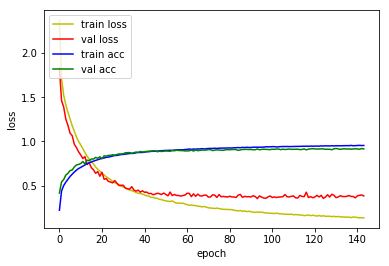

4815/4815 [==============================] - 2s 397us/sample - loss: 0.4294 - acc: 0.8856
Loss: 0.42937957885233163 Accuracy: 0.88556594

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4797 - acc: 0.1874
Epoch 00001: val_loss improved from inf to 1.89325, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_7_conv_checkpoint/001-1.8932.hdf5
36805/36805 [==============================] - 30s 811us/sample - loss: 2.4796 - acc: 0.1875 - val_loss: 1.8932 - val_acc: 0.4030
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.6840 - acc: 0.4456
Epoch 00002: val_loss improved from 1.89325 to 1.31142, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_7_conv_checkpoint/002-1.3114.hdf5
36805/36805 [==============================] - 27s 726us/sample - loss: 1.6834 - acc: 0.4459 - val_loss: 1.3114 - val_acc: 0.5763
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - 

Epoch 23/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3701 - acc: 0.8851
Epoch 00023: val_loss did not improve from 0.30993
36805/36805 [==============================] - 27s 726us/sample - loss: 0.3700 - acc: 0.8851 - val_loss: 0.3125 - val_acc: 0.9161
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.3579 - acc: 0.8881
Epoch 00024: val_loss did not improve from 0.30993
36805/36805 [==============================] - 26s 719us/sample - loss: 0.3578 - acc: 0.8881 - val_loss: 0.3151 - val_acc: 0.9099
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3508 - acc: 0.8905
Epoch 00025: val_loss improved from 0.30993 to 0.30483, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_7_conv_checkpoint/025-0.3048.hdf5
36805/36805 [==============================] - 27s 723us/sample - loss: 0.3507 - acc: 0.8905 - val_loss: 0.3048 - val_acc: 0.9124
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1988 - acc: 0.9345
Epoch 00050: val_loss did not improve from 0.21732
36805/36805 [==============================] - 27s 723us/sample - loss: 0.1987 - acc: 0.9345 - val_loss: 0.2299 - val_acc: 0.9366
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1956 - acc: 0.9345
Epoch 00051: val_loss did not improve from 0.21732
36805/36805 [==============================] - 27s 722us/sample - loss: 0.1955 - acc: 0.9345 - val_loss: 0.2325 - val_acc: 0.9394
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1930 - acc: 0.9360
Epoch 00052: val_loss improved from 0.21732 to 0.21635, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_7_conv_checkpoint/052-0.2163.hdf5
36805/36805 [==============================] - 27s 729us/sample - loss: 0.1929 - acc: 0.9360 - val_loss: 0.2163 - val_acc: 0.9406
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 77/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1331 - acc: 0.9550
Epoch 00077: val_loss did not improve from 0.18941
36805/36805 [==============================] - 26s 716us/sample - loss: 0.1333 - acc: 0.9550 - val_loss: 0.2042 - val_acc: 0.9457
Epoch 78/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1313 - acc: 0.9559
Epoch 00078: val_loss did not improve from 0.18941
36805/36805 [==============================] - 27s 726us/sample - loss: 0.1312 - acc: 0.9559 - val_loss: 0.2047 - val_acc: 0.9471
Epoch 79/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1311 - acc: 0.9557
Epoch 00079: val_loss did not improve from 0.18941
36805/36805 [==============================] - 27s 721us/sample - loss: 0.1313 - acc: 0.9557 - val_loss: 0.1997 - val_acc: 0.9509
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1277 - acc: 0.9571
Epoch 00080: val_loss did not improve from 0.18941
36805/36805 [=====

Epoch 106/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0959 - acc: 0.9672
Epoch 00106: val_loss did not improve from 0.18597
36805/36805 [==============================] - 27s 723us/sample - loss: 0.0959 - acc: 0.9672 - val_loss: 0.1976 - val_acc: 0.9495
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0936 - acc: 0.9671
Epoch 00107: val_loss did not improve from 0.18597
36805/36805 [==============================] - 26s 717us/sample - loss: 0.0936 - acc: 0.9671 - val_loss: 0.1894 - val_acc: 0.9541
Epoch 108/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9662
Epoch 00108: val_loss did not improve from 0.18597
36805/36805 [==============================] - 27s 724us/sample - loss: 0.0976 - acc: 0.9662 - val_loss: 0.1942 - val_acc: 0.9532
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0944 - acc: 0.9677
Epoch 00109: val_loss did not improve from 0.18597
36805/36805 [=

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0716 - acc: 0.9752
Epoch 00136: val_loss did not improve from 0.18597
36805/36805 [==============================] - 26s 716us/sample - loss: 0.0716 - acc: 0.9752 - val_loss: 0.2115 - val_acc: 0.9546

1D_CNN_custom_3_ch_32_DO_7_conv Model


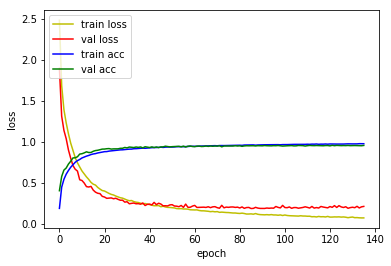

4815/4815 [==============================] - 2s 411us/sample - loss: 0.2336 - acc: 0.9319
Loss: 0.23356248641682562 Accuracy: 0.9318795

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5101 - acc: 0.1821
Epoch 00001: val_loss improved from inf to 1.75631, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_8_conv_checkpoint/001-1.7563.hdf5
36805/36805 [==============================] - 31s 847us/sample - loss: 2.5099 - acc: 0.1822 - val_loss: 1.7563 - val_acc: 0.4673
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.5951 - acc: 0.4845
Epoch 00002: val_loss improved from 1.75631 to 1.09105, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_8_conv_checkpoint/002-1.0911.hdf5
36805/36805 [==============================] - 27s 747us/sample - loss: 1.5944 - acc: 0.4847 - val_loss: 1.0911 - val_acc: 0.6553
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - l

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2627 - acc: 0.9156
Epoch 00023: val_loss improved from 0.20413 to 0.19708, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_8_conv_checkpoint/023-0.1971.hdf5
36805/36805 [==============================] - 27s 746us/sample - loss: 0.2628 - acc: 0.9156 - val_loss: 0.1971 - val_acc: 0.9380
Epoch 24/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.2555 - acc: 0.9191
Epoch 00024: val_loss improved from 0.19708 to 0.18646, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_8_conv_checkpoint/024-0.1865.hdf5
36805/36805 [==============================] - 27s 740us/sample - loss: 0.2554 - acc: 0.9191 - val_loss: 0.1865 - val_acc: 0.9392
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2464 - acc: 0.9210
Epoch 00025: val_loss improved from 0.18646 to 0.18028, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_8_conv_checkpoint/025-0.1803.hdf5
36805

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1321 - acc: 0.9549
Epoch 00049: val_loss did not improve from 0.14318
36805/36805 [==============================] - 27s 744us/sample - loss: 0.1321 - acc: 0.9550 - val_loss: 0.1510 - val_acc: 0.9562
Epoch 50/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1349 - acc: 0.9550
Epoch 00050: val_loss did not improve from 0.14318
36805/36805 [==============================] - 27s 743us/sample - loss: 0.1349 - acc: 0.9551 - val_loss: 0.1597 - val_acc: 0.9543
Epoch 51/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.1336 - acc: 0.9561
Epoch 00051: val_loss did not improve from 0.14318
36805/36805 [==============================] - 27s 740us/sample - loss: 0.1336 - acc: 0.9561 - val_loss: 0.1553 - val_acc: 0.9555
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1284 - acc: 0.9565
Epoch 00052: val_loss did not improve from 0.14318
36805/36805 [=====

Epoch 78/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0812 - acc: 0.9722
Epoch 00078: val_loss did not improve from 0.13715
36805/36805 [==============================] - 27s 744us/sample - loss: 0.0812 - acc: 0.9722 - val_loss: 0.1437 - val_acc: 0.9590
Epoch 79/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0818 - acc: 0.9723
Epoch 00079: val_loss did not improve from 0.13715
36805/36805 [==============================] - 28s 747us/sample - loss: 0.0817 - acc: 0.9723 - val_loss: 0.1472 - val_acc: 0.9595
Epoch 80/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9726
Epoch 00080: val_loss did not improve from 0.13715
36805/36805 [==============================] - 27s 741us/sample - loss: 0.0788 - acc: 0.9726 - val_loss: 0.1523 - val_acc: 0.9560
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9724
Epoch 00081: val_loss did not improve from 0.13715
36805/36805 [=====

Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0557 - acc: 0.9815
Epoch 00108: val_loss did not improve from 0.13715
36805/36805 [==============================] - 27s 741us/sample - loss: 0.0557 - acc: 0.9815 - val_loss: 0.1606 - val_acc: 0.9606
Epoch 109/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9812
Epoch 00109: val_loss did not improve from 0.13715
36805/36805 [==============================] - 27s 739us/sample - loss: 0.0542 - acc: 0.9811 - val_loss: 0.1499 - val_acc: 0.9644
Epoch 110/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9792
Epoch 00110: val_loss did not improve from 0.13715
36805/36805 [==============================] - 27s 735us/sample - loss: 0.0593 - acc: 0.9792 - val_loss: 0.1618 - val_acc: 0.9611
Epoch 111/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0543 - acc: 0.9808
Epoch 00111: val_loss did not improve from 0.13715
36805/36805 [=

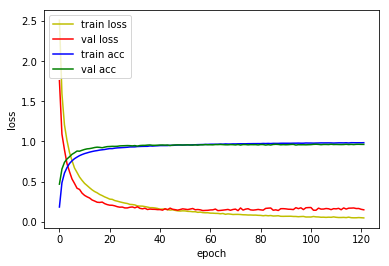

4815/4815 [==============================] - 2s 389us/sample - loss: 0.1771 - acc: 0.9479
Loss: 0.17710612370155807 Accuracy: 0.9478712

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.2273 - acc: 0.2774
Epoch 00001: val_loss improved from inf to 1.44332, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_9_conv_checkpoint/001-1.4433.hdf5
36805/36805 [==============================] - 32s 876us/sample - loss: 2.2268 - acc: 0.2775 - val_loss: 1.4433 - val_acc: 0.5572
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 1.4162 - acc: 0.5429
Epoch 00002: val_loss improved from 1.44332 to 1.04406, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_9_conv_checkpoint/002-1.0441.hdf5
36805/36805 [==============================] - 27s 744us/sample - loss: 1.4158 - acc: 0.5430 - val_loss: 1.0441 - val_acc: 0.6783
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2197 - acc: 0.9296
Epoch 00024: val_loss improved from 0.17645 to 0.17516, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_9_conv_checkpoint/024-0.1752.hdf5
36805/36805 [==============================] - 27s 745us/sample - loss: 0.2197 - acc: 0.9296 - val_loss: 0.1752 - val_acc: 0.9455
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2097 - acc: 0.9331
Epoch 00025: val_loss improved from 0.17516 to 0.17309, saving model to model/checkpoint/1D_CNN_custom_3_ch_32_DO_9_conv_checkpoint/025-0.1731.hdf5
36805/36805 [==============================] - 28s 747us/sample - loss: 0.2097 - acc: 0.9331 - val_loss: 0.1731 - val_acc: 0.9469
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1931 - acc: 0.9368
Epoch 00026: val_loss did not improve from 0.17309
36805/36805 [==============================] - 28s 747us/sample - loss: 0.1930 - acc: 0.9368 - val_los

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9673
Epoch 00051: val_loss did not improve from 0.14810
36805/36805 [==============================] - 27s 744us/sample - loss: 0.0930 - acc: 0.9673 - val_loss: 0.1708 - val_acc: 0.9539
Epoch 52/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9713
Epoch 00052: val_loss did not improve from 0.14810
36805/36805 [==============================] - 27s 744us/sample - loss: 0.0848 - acc: 0.9713 - val_loss: 0.1544 - val_acc: 0.9562
Epoch 53/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0875 - acc: 0.9708
Epoch 00053: val_loss did not improve from 0.14810
36805/36805 [==============================] - 27s 746us/sample - loss: 0.0873 - acc: 0.9708 - val_loss: 0.1576 - val_acc: 0.9583
Epoch 54/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0834 - acc: 0.9718
Epoch 00054: val_loss did not improve from 0.14810
36805/36805 [=====

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0478 - acc: 0.9829
Epoch 00081: val_loss did not improve from 0.14810
36805/36805 [==============================] - 27s 744us/sample - loss: 0.0477 - acc: 0.9829 - val_loss: 0.1852 - val_acc: 0.9576
Epoch 82/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0486 - acc: 0.9822
Epoch 00082: val_loss did not improve from 0.14810
36805/36805 [==============================] - 27s 742us/sample - loss: 0.0487 - acc: 0.9821 - val_loss: 0.1815 - val_acc: 0.9604
Epoch 83/500
36736/36805 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9849
Epoch 00083: val_loss did not improve from 0.14810
36805/36805 [==============================] - 27s 745us/sample - loss: 0.0447 - acc: 0.9849 - val_loss: 0.1748 - val_acc: 0.9618
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0465 - acc: 0.9833
Epoch 00084: val_loss did not improve from 0.14810
36805/36805 [=====

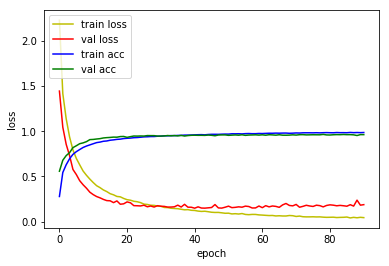

4815/4815 [==============================] - 2s 411us/sample - loss: 0.2086 - acc: 0.9406
Loss: 0.20855384672375885 Accuracy: 0.9406023



In [10]:
for i in range(4, 10):
    base = '1D_CNN_custom_3_ch_32_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_3_ch_32_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(4, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_ch_32_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 32)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 64)          10304     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 5

4815/4815 [==============================] - 2s 431us/sample - loss: 0.2336 - acc: 0.9319
Loss: 0.23356248641682562 Accuracy: 0.9318795

1D_CNN_custom_3_ch_32_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 32)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (Non

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(4, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_3_ch_32_DO_4_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1777, 32)          0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 1777, 64)          10304     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 5

4815/4815 [==============================] - 2s 474us/sample - loss: 0.2505 - acc: 0.9381
Loss: 0.25048343313941085 Accuracy: 0.93811005

1D_CNN_custom_3_ch_32_DO_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 5333, 32)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 5333, 32)          5152      
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 1777, 32)          0         
_________________________________________________________________
conv1d_70 (Conv1D)           (No